# Simulate two 1D place cells on a 1 m linear track
 - bidirectional Gaussian place fields (same response both travel directions)
 - rat moves with smoothly-varying velocity (OU process) and reflects at boundaries
 - spikes generated by inhomogeneous Poisson process (Bernoulli per dt)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Simulation parameters
track_length = 1.0  # meters
dt = 0.01  # time step (s) -> 100 Hz sampling
T = 300.0  # total time (s)
n_steps = int(T / dt)
time = np.arange(n_steps) * dt

# Velocity OU process parameters (produce smoothly varying speed & direction)
theta = 1.0   # mean reversion
mu = 0.0      # long-run mean velocity (m/s)
sigma = 0.4   # volatility of velocity (m/s * sqrt(s))
v0 = 0.0      # initial velocity

# Initialize arrays
pos = np.zeros(n_steps)
vel = np.zeros(n_steps)
pos[0] = 0.5  # start in middle
vel[0] = v0

rng = np.random.default_rng(42)

# simulate velocity (OU) and integrate to position with reflecting boundaries
for t in range(n_steps - 1):
    vel[t+1] = vel[t] + theta * (mu - vel[t]) * dt + sigma * np.sqrt(dt) * rng.standard_normal()
    pos[t+1] = pos[t] + vel[t+1] * dt
    # reflect at boundaries
    if pos[t+1] < 0:
        pos[t+1] = -pos[t+1]
        vel[t+1] = -vel[t+1]
    elif pos[t+1] > track_length:
        pos[t+1] = 2*track_length - pos[t+1]
        vel[t+1] = -vel[t+1]

# Define two place fields (Gaussian)
centers = np.array([0.25, 0.75])  # meters
sigma_pf = 0.15  # place field width (m)
peak_rates = np.array([20.0, 16.0])  # peak firing rates (Hz)
baseline_rate = 0.1  # baseline (Hz)

n_neurons = len(centers)
rates = np.zeros((n_neurons, n_steps))
for i in range(n_neurons):
    rates[i] = baseline_rate + peak_rates[i] * np.exp(-0.5 * ((pos - centers[i]) / sigma_pf)**2)

# Generate spikes: Bernoulli approximation for inhomogeneous Poisson
rng = np.random.default_rng(123)  # new rng for spikes
spikes = rng.random(size=(n_neurons, n_steps)) < (rates * dt)

# Extract spike times and positions
spike_times = [time[spikes[i]] for i in range(n_neurons)]
spike_positions = [pos[spikes[i]] for i in range(n_neurons)]
spike_counts = np.sum(spikes, axis=1)

# Empirical rate maps (bins)
n_bins = 50
bins = np.linspace(0, track_length, n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
occupancy, _ = np.histogram(pos, bins=bins)
occupancy_time = occupancy * dt
empirical_rate_maps = np.zeros((n_neurons, n_bins))
for i in range(n_neurons):
    sc, _ = np.histogram(spike_positions[i], bins=bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        empirical_rate_maps[i] = np.where(occupancy_time > 0, sc / occupancy_time, 0.0)

# Theoretical rate over continuous x (for plotting)
x = np.linspace(0, track_length, 500)
theoretical_rates = np.zeros((n_neurons, x.size))
for i in range(n_neurons):
    theoretical_rates[i] = baseline_rate + peak_rates[i] * np.exp(-0.5 * ((x - centers[i]) / sigma_pf)**2)


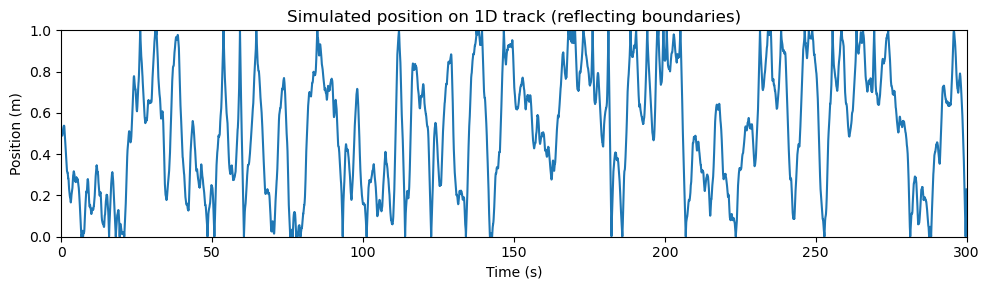

In [4]:

# ---------------- PLOTS ----------------
plt.figure(figsize=(10, 3))
plt.plot(time, pos)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Simulated position on 1D track (reflecting boundaries)')
plt.xlim(0, T)
plt.ylim(0, track_length)
plt.tight_layout()
plt.show()


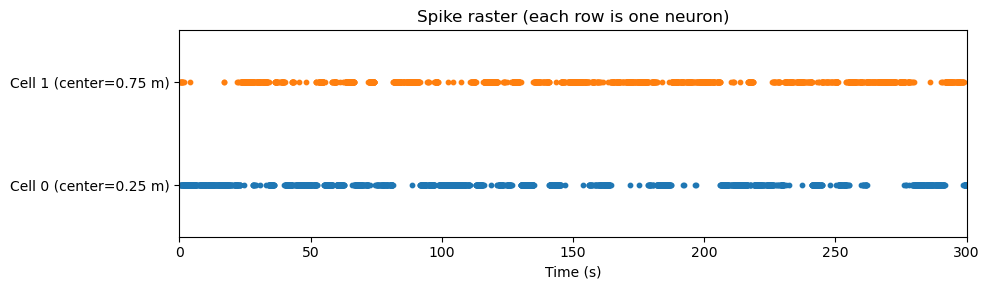

In [5]:
# Spike raster
plt.figure(figsize=(10, 2 + 0.5 * n_neurons))
for i in range(n_neurons):
    plt.scatter(spike_times[i], np.ones_like(spike_times[i]) * i, s=10)
plt.yticks(np.arange(n_neurons), [f'Cell {i} (center={centers[i]:.2f} m)' for i in range(n_neurons)])
plt.xlabel('Time (s)')
plt.title('Spike raster (each row is one neuron)')
plt.ylim(-0.5, n_neurons - 0.5)
plt.xlim(0, T)
plt.tight_layout()
plt.show()



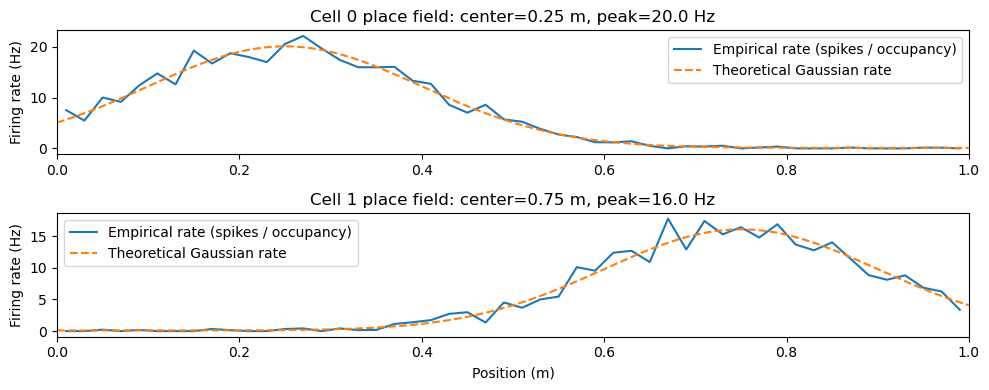

In [6]:
# Empirical rate maps vs theoretical
plt.figure(figsize=(10, 4))
for i in range(n_neurons):
    plt.subplot(n_neurons, 1, i+1)
    plt.plot(bin_centers, empirical_rate_maps[i], label='Empirical rate (spikes / occupancy)')
    plt.plot(x, theoretical_rates[i], label='Theoretical Gaussian rate', linestyle='--')
    plt.ylabel('Firing rate (Hz)')
    plt.title(f'Cell {i} place field: center={centers[i]:.2f} m, peak={peak_rates[i]} Hz')
    plt.xlim(0, track_length)
    plt.legend()
plt.xlabel('Position (m)')
plt.tight_layout()
plt.show()

